In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from pprint import pprint
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt

import cellcycle.PlottingTools as plottingTools
from cellcycle.ParameterSet import ParameterSet
import cellcycle.DataStorage as dataStorage
import cellcycle.DataAnalysis as dataAnalysis
import cellcycle.MakeDataframe as makeDataframe
import cellcycle.MakeDataframe as makeDataframe
from cellcycle import mainClass

In [2]:
file_path_input_params_json = '../../input_params.json'
input_param_dict = mainClass.extract_variables_from_input_params_json(file_path_input_params_json)
root_path = input_param_dict["DATA_FOLDER_PATH"]
simulation_location = 'SI/S18_vary_total_conc'
file_path = os.path.join(root_path, simulation_location)
print('file_path', file_path)
parameter_path = os.path.join(file_path, 'parameter_set.csv')
print('parameter_path', parameter_path)

file_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S18_vary_total_conc
parameter_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S18_vary_total_conc/parameter_set.csv


In [3]:
pinkish_red = (247 / 255, 109 / 255, 109 / 255)
green = (0 / 255, 133 / 255, 86 / 255)
dark_blue = (36 / 255, 49 / 255, 94 / 255)
light_blue = (168 / 255, 209 / 255, 231 / 255)
blue = (55 / 255, 71 / 255, 133 / 255)
yellow = (247 / 255, 233 / 255, 160 / 255)

In [4]:
v_init_exp = 0.28
std_exp = 0.05

In [5]:
data_frame = makeDataframe.make_dataframe(file_path)
data_frame = makeDataframe.add_average_values_to_df(data_frame)
data_frame = makeDataframe.add_theoretical_init_reg_concentrations_to_df(data_frame)
data_frame.simu_name

['/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S18_vary_total_conc/low_growth_rate_variation',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S18_vary_total_conc/high_growth_vary_total_conc',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S18_vary_total_conc/S17_vary_total_conc.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S18_vary_total_conc/v_init_vary_total_conc.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S18_vary_total_conc/intermed',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S18_vary_total_conc/S17_vary_total_conc.svg']


0       low_growth_rate_variation
1       low_growth_rate_variation
2       low_growth_rate_variation
3       low_growth_rate_variation
4       low_growth_rate_variation
5       low_growth_rate_variation
6       low_growth_rate_variation
7       low_growth_rate_variation
8       low_growth_rate_variation
9       low_growth_rate_variation
10    high_growth_vary_total_conc
11    high_growth_vary_total_conc
12    high_growth_vary_total_conc
13    high_growth_vary_total_conc
14    high_growth_vary_total_conc
15    high_growth_vary_total_conc
16    high_growth_vary_total_conc
17    high_growth_vary_total_conc
18    high_growth_vary_total_conc
19    high_growth_vary_total_conc
20                       intermed
21                       intermed
22                       intermed
23                       intermed
24                       intermed
25                       intermed
26                       intermed
27                       intermed
28                       intermed
29            

# Calculate CV

In [6]:
for simu_name in data_frame.simu_name.unique():
    simu_df = data_frame[data_frame["simu_name"] == simu_name]
    print(simu_name)
    data_frame.loc[data_frame['simu_name'] == simu_name, 'mean_v_init_per_n_ori'] = np.mean(simu_df["v_init_per_n_ori"])
    data_frame.loc[data_frame['simu_name'] == simu_name, 'stdd_v_init_per_n_ori'] = np.std(simu_df["v_init_per_n_ori"])
    data_frame.loc[data_frame['simu_name'] == simu_name, 'cv_v_init_per_n_ori'] = np.std(simu_df["v_init_per_n_ori"])/np.mean(simu_df["v_init_per_n_ori"])

low_growth_rate_variation
high_growth_vary_total_conc
intermed


# Calculate variance at different growth rates

In [7]:
def return_array_of_initiation_volumes(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_init_events')
    return data_frame['v_init_per_ori'], data_frame['t_init']

def calculate_CV_v_init(row):
    v_init_per_ori, t_init = return_array_of_initiation_volumes(row.path_dataset)
    v_init_np = v_init_per_ori.to_numpy()
    return np.std(v_init_np[10:])/np.mean(v_init_np[10:])

def calculate_mean_v_init(row):
    v_init_per_ori, t_init = return_array_of_initiation_volumes(row.path_dataset)
    v_init_np = v_init_per_ori.to_numpy()
    return np.mean(v_init_np[10:])

def calculate_mean_ori_init_density(row):
    v_init_per_ori, t_init = return_array_of_initiation_volumes(row.path_dataset)
    v_init_np = v_init_per_ori.to_numpy()
    return 1/np.mean(v_init_np[10:])

def calculate_mean_total_conc(row):
    time_traces_data_frame = pd.read_hdf(row.path_dataset, key='dataset_time_traces')
    N_init = np.array(time_traces_data_frame["N_init"])
    volume = np.array(time_traces_data_frame["volume"])
    total_conc = np.array(N_init / volume)
    return np.mean(total_conc[int(total_conc.size/2):])

def calculate_mean_active_frac(row):
    time_traces_data_frame = pd.read_hdf(row.path_dataset, key='dataset_time_traces')
    active_frac = np.array(time_traces_data_frame["active_fraction"])
    return np.mean(active_frac[int(active_frac.size/2):])

data_frame["CV_v_init"] = data_frame.apply(lambda row: calculate_CV_v_init(row), axis=1)
data_frame["mean_v_init_per_ori"] = data_frame.apply(lambda row: calculate_mean_v_init(row), axis=1)
data_frame["mean_ori_init_density"] = data_frame.apply(lambda row: calculate_mean_ori_init_density(row), axis=1)
data_frame["mean_total_conc"] = data_frame.apply(lambda row: calculate_mean_total_conc(row), axis=1)
data_frame["mean_active_frac"] = data_frame.apply(lambda row: calculate_mean_active_frac(row), axis=1)
data_frame.doubling_rate

0     0.500000
1     0.500000
2     0.500000
3     0.500000
4     0.500000
5     0.500000
6     0.500000
7     0.500000
8     0.500000
9     0.500000
10    2.400000
11    2.400000
12    2.400000
13    2.400000
14    2.400000
15    2.400000
16    2.400000
17    2.400000
18    2.400000
19    2.400000
20    1.714286
21    1.714286
22    1.714286
23    1.714286
24    1.714286
25    1.714286
26    1.714286
27    1.714286
28    1.714286
29    1.714286
Name: doubling_rate, dtype: float64

# Relative changes in total conc and v_init

In [8]:
def calculate_mean_total_conc_rel(row, data_frame):
    print('doubling rate: ',row.doubling_rate)
#     print(data_frame.loc[data_frame['doubling_rate']==row.doubling_rate]['mean_total_conc'])
    WT_total_conc = data_frame.loc[(data_frame['doubling_rate']==row.doubling_rate) & (data_frame['offset_oscillations']==0)]['mean_total_conc']
    print('WT total_conc', WT_total_conc.iloc[0])
    return row.mean_total_conc / WT_total_conc.iloc[0]

def calculate_mean_v_init_rel(row, data_frame):
    WT_v_init = data_frame.loc[(data_frame['doubling_rate']==row.doubling_rate) & (data_frame['offset_oscillations']==0)]['mean_v_init_per_ori']
    print('WT v_init', WT_v_init.iloc[0])
    return row.mean_v_init_per_ori / WT_v_init.iloc[0]

data_frame["mean_total_conc_rel"] = data_frame.apply(lambda row: calculate_mean_total_conc_rel(row, data_frame),
                                                         axis=1)
data_frame["mean_v_init_per_ori_rel"] = data_frame.apply(lambda row: calculate_mean_v_init_rel(row, data_frame),
                                                         axis=1)

doubling rate:  0.5
WT total_conc 1432.4778961303268
doubling rate:  0.5
WT total_conc 1432.4778961303268
doubling rate:  0.5
WT total_conc 1432.4778961303268
doubling rate:  0.5
WT total_conc 1432.4778961303268
doubling rate:  0.5
WT total_conc 1432.4778961303268
doubling rate:  0.5
WT total_conc 1432.4778961303268
doubling rate:  0.5
WT total_conc 1432.4778961303268
doubling rate:  0.5
WT total_conc 1432.4778961303268
doubling rate:  0.5
WT total_conc 1432.4778961303268
doubling rate:  0.5
WT total_conc 1432.4778961303268
doubling rate:  2.4
WT total_conc 1098.8684823656454
doubling rate:  2.4
WT total_conc 1098.8684823656454
doubling rate:  2.4
WT total_conc 1098.8684823656454
doubling rate:  2.4
WT total_conc 1098.8684823656454
doubling rate:  2.4
WT total_conc 1098.8684823656454
doubling rate:  2.4
WT total_conc 1098.8684823656454
doubling rate:  2.4
WT total_conc 1098.8684823656454
doubling rate:  2.4
WT total_conc 1098.8684823656454
doubling rate:  2.4
WT total_conc 1098.8684823

# Make Legends

In [9]:
import math

def make_production_rate_datA_lipids_cv_legend(activation_rate_lipids, block_production):
    return r'$\alpha_{{\rm lipids}}={}$ /h, blocked = {}'.format(np.round(activation_rate_lipids,3),
                                                               block_production)
def make_legend_lipids(activation_rate_lipids):
    if activation_rate_lipids == 0:
        return 'Full model (no lipids)'
    else:
        return 'Full model'
def make_legend_model_type(version_of_model):
    if version_of_model == 'switch':
        return
    
def make_legend_LD_opt(n_c_max_0, CV_v_init):
    if n_c_max_0 == 0:
        return 'switch, CV={}'.format(np.round(CV_v_init, 3))
    else:
        return 'switch + titration, CV={}'.format(np.round(CV_v_init, 3))
    
def make_legend_blocked(block_production):
    if block_production == 0:
        return 'not blocked'
    else:
        return 'blocked'
    
def make_production_rate_datA_cv_legend(destruction_rate_datA, cv):
    return r'$\beta_{{\rm datA}}={}$ /h, CV= {}'.format(np.round(destruction_rate_datA,3),
                                                        np.round(cv,3))

def make_production_rate_datA_legend(destruction_rate_datA):
    return r'$\beta_{{\rm datA}}={}$ min$^{{-1}}$'.format(int(destruction_rate_datA/60))

def make_production_rate_datA_lipids_legend(destruction_rate_datA, production_rate_lipids):
    return r'$\beta_{{\rm datA}}={}$ /h, \linebreak  $\alpha_{{\rm lipids}}={}$ /h'.format(np.round(destruction_rate_datA,3), 
                                                                                       np.round(production_rate_lipids,3))

def make_theoretical_v_init_legend(v_init_per_n_ori_th_no_time_varying):
    return r'$v^\ast_{{\rm th}}={} \, \mu $m$^3$'.format(np.round(v_init_per_n_ori_th_no_time_varying,3))

def make_legend_model(version_of_model):
    if version_of_model == 'switch':
        return 'LD (opt)'
    else:
        return 'LD + titration (opt)'

def make_order(legend_models):
    if legend_models == 'titration':
        return 1
    if legend_models == 'titration+SeqA':
        return 2
    if legend_models == 'LDDR':
        return 3
    if legend_models == 'LDDR+titration':
        return 4
    if legend_models == 'LDDR+titration+SeqA':
        return 5

def make_doubling_time_legend(doubling_rate):
    return r'$\tau_{{\rm d}}={}$ min'.format(int(1/doubling_rate*60))

data_frame.loc[:, 'legend_datA_lipids_cv'] = data_frame.apply(lambda row: make_production_rate_datA_lipids_cv_legend(row.activation_rate_lipids,row.block_production), axis = 1)
data_frame.loc[:, 'legend_lipids'] = data_frame.apply(lambda row: make_legend_lipids(row.activation_rate_lipids), axis = 1)
data_frame.loc[:, 'DnaA synthesis:'] = data_frame.apply(lambda row: make_legend_blocked(row.block_production), axis = 1)
data_frame.loc[:, 'legend_opt'] = data_frame.apply(lambda row: make_legend_LD_opt(row.n_c_max_0, row.CV_v_init), axis = 1)
data_frame.loc[:, 'legend_model'] = data_frame.apply(lambda row: make_legend_model(row.version_of_model), axis = 1)
data_frame.loc[:, 'Doubling time:'] = data_frame.apply(lambda row: make_doubling_time_legend(row.doubling_rate), axis = 1)



# Determine minimal activator fraction

In [10]:
def determine_min_frac(filepath_h5, total_conc):
    data_frame_traces = pd.read_hdf(filepath_h5, key='dataset_time_traces')
    fractions = data_frame_traces['active_conc'] / total_conc
    return np.min(fractions[int(fractions.size/2):])

def determine_max_frac(filepath_h5, total_conc):
    data_frame_traces = pd.read_hdf(filepath_h5, key='dataset_time_traces')
    fractions = data_frame_traces['active_conc'] / total_conc
    return np.max(fractions[int(fractions.size/2):])

data_frame.loc[:, 'min_frac'] = data_frame.apply(lambda row: determine_min_frac(row.path_dataset, row.total_conc), axis = 1)
data_frame.loc[:, 'max_frac'] = data_frame.apply(lambda row: determine_max_frac(row.path_dataset, row.total_conc), axis = 1)
data_frame['amplitude_frac'] = data_frame['max_frac']-data_frame['min_frac']
data_frame['relative_change_frac']= data_frame['min_frac']/data_frame['max_frac']

# Plot average initiation volume for different total concentrations

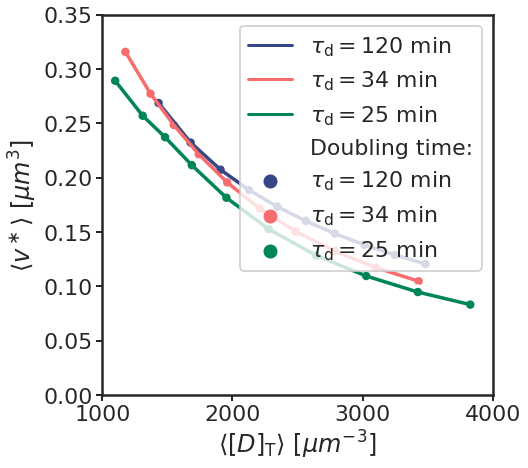

In [11]:
sns.set(style="ticks")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(
    x='mean_total_conc', 
    y='mean_v_init_per_ori',
    data=data_frame.sort_values(by=["version_of_model"], ascending=True),
    hue='Doubling time:',
#     dashes=[(4, 1), (4, 1), (4, 1), (4, 1)],
#     style ='lddr',
#     markers=True,
    palette= [blue, pinkish_red, green], #, light_blue],#, yellow],
    linewidth = 3.5,
    ax=ax
);
ax.get_legend().remove()
sns.lineplot(
    x='mean_total_conc', 
    y='mean_v_init_per_ori',
    data=data_frame.sort_values(by=["version_of_model"], ascending=True),
    hue='Doubling time:',
#     dashes=[(4, 1), (4, 1), (4, 1), (4, 1)],
#     style ='lddr',
#     markers=True,
    palette= [blue, pinkish_red, green], #, light_blue],#, yellow],
    linewidth = 3.5,
    ax=ax
);
# ax.plot(np.linspace(1000, 4000, 100), 
#         300/np.linspace(1000, 4000, 100), 
#         label= r'$n_s/[D]_{\rm T}$', color='grey',
#        linestyle='dashed')
ax.margins(0)
ax.set(xlabel=r'$\langle [D]_{\rm T} \rangle$ $[\mu m^{-3}]$', ylabel=r'$\langle v^\ast \rangle$ $[\mu m^{3}]$')
# plt.legend(labels=legend)
ax.set(ylim=(0,0.35))
ax.set(xlim=(1000,4000))
ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.savefig(file_path + '/v_init_vary_total_conc.pdf', format='pdf', bbox_inches='tight')

# Plot relative initiation volume for different total concentrations

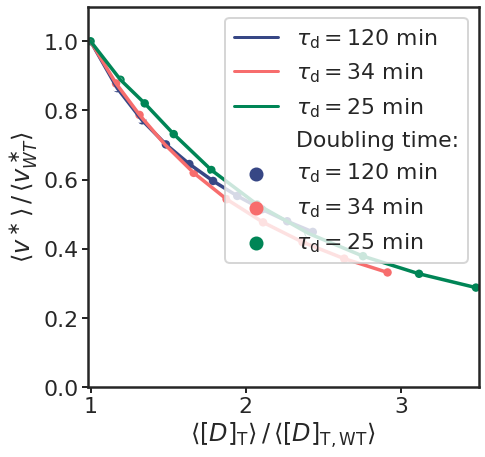

In [12]:
sns.set(style="ticks")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(
    x='mean_total_conc_rel', 
    y='mean_v_init_per_ori_rel',
    data=data_frame.sort_values(by=["version_of_model"], ascending=True),
    hue='Doubling time:',
#     dashes=[(4, 1), (4, 1), (4, 1), (4, 1)],
#     style ='lddr',
#     markers=True,
    palette= [blue, pinkish_red, green], #, light_blue],#, yellow],
    linewidth = 3.5,
    ax=ax
);
ax.get_legend().remove()
sns.lineplot(
    x='mean_total_conc_rel', 
    y='mean_v_init_per_ori_rel',
    data=data_frame.sort_values(by=["version_of_model"], ascending=True),
    hue='Doubling time:',
#     dashes=[(4, 1), (4, 1), (4, 1), (4, 1)],
#     style ='lddr',
#     markers=True,
    palette= [blue, pinkish_red, green], #, light_blue],#, yellow],
    linewidth = 3.5,
    ax=ax
);
# ax.plot(np.linspace(1000, 4000, 100), 
#         300/np.linspace(1000, 4000, 100), 
#         label= r'$n_s/[D]_{\rm T}$', color='grey',
#        linestyle='dashed')
ax.margins(0)
ax.set(xlabel=r'$\langle [D]_{\rm T} \rangle \, / \, \langle [D]_{\rm T, WT} \rangle$', ylabel=r'$\langle v^\ast \rangle \, / \, \langle v^\ast_{WT} \rangle$')
# plt.legend(labels=legend)
ax.set(ylim=(0,1.1))
# ax.set(xlim=(1,4))
ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.savefig(file_path + '/v_init_vary_total_conc.pdf', format='pdf', bbox_inches='tight')